# Fortune's sweeping algorithm for finding Voronoi diagram

### Visualisation tool for plotting the data
provided by the teacher

In [1]:
# The tool for visualisation requires several modules/libraries 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parameter for tolerance of closing a polygon while inputing it
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Class for holding the plot's state and some onclick button functionalities
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # moving to the next scene
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # moving to the previous scene
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # methods for shape input 
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            

    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))


    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # method that implements the logic behind drawing new plot elements
    # depending on it's mode it can add new points, beginning or ending of a line
    # or polygon vertices  
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Method for plotting the the elements on the main plot
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
# the 'Scene' class holds all elements that are to be plotted at the same time
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# PointsCollection stores points of the same type - 
# such points share the color and size/shape of the marker
# points are passed as a (x,y) tuple value for X and Y coordinates respectively      
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# PointsCollection stores lines of the same type
# lines are passed as a ((x1,y1),(x2,y2)) tuple value 
# for the coordinates of the beginning and the end of the line      
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Plot is the most important class of the visualisation
# It stores all prepared scenes, button references and creates the plot
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # saving to json file
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # the method returns added scene
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # method that shows the plot
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
    def save(self, scene_index, path='.'):
        plt.close()
        ax = plt.axes()
        plt.axis('square')
        scene = self.scenes[scene_index]
        for collection in scene.points:
            if len(collection.points) > 0:
                ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (scene.lines):
            ax.add_collection(collection.get_collection())
        ax.autoscale(True)
        plt.savefig(path+"/figure_"+str(scene_index)+".png")
        

# Task solution

In [3]:
%matplotlib notebook

In [4]:
import functools
import sortedcontainers
import copy as cp
from math import sqrt
from queue import PriorityQueue
from random import *
import time

### Math functions

In [5]:
# method that finds such point (x,y) on a circle that goes through p0,p1,p2 points
# that the value of y is as low as possible. In other words. It finds the 'bottom' of the circle
def circle_minimum(p0,p1,p2):
        k=2*(p1[0]-p0[0])
        l=2*(p1[1]-p0[1])
        m= p0[0]*p0[0] - p1[0]*p1[0] + p0[1]*p0[1] - p1[1]*p1[1] 
        p=2*(p2[0]-p0[0])
        q=2*(p2[1]-p0[1])
        r=p0[0]*p0[0] - p2[0]*p2[0] + p0[1]*p0[1] - p2[1]*p2[1]
        
        a = (r*l-m*q)/(k*q-p*l)
        b = (r*k-m*p)/(p*l-k*q)
        r = sqrt((p0[0]-a)**2 + (p0[1]-b)**2)
        return b-r

In [6]:
# function that finds a left oriented vector perpendicular to (pl,pr) line
def get_vector(pl,pr):
    return (pl[1]-pr[1],pr[0]-pl[0])

In [7]:
# function that determines the position of point c with respect to ab line
def side_of_c(a,b,c): 
    tab = np.array([[a[0]-c[0], a[1]-c[1]],[b[0]-c[0], b[1]-c[1]]])
    d = np.linalg.det(tab)
    if d > 0:
        return -1 # c is on the left of ab
    elif d == 0:
        return 0 # c os on a line passing through ab
    else: 
        return 1 # c is on the right of ab


In [8]:
# Finding visualisation borders

# the intersection of a line given by vector and a line given by an y coordinate
def get_y_intersect(y,vector,point):
    x = (y-point[1])*vector[0]/vector[1]+point[0]
    return x,y

# the intersection of a line given by vector and a line given by an x coordinate
def get_x_intersect(x,vector,point):
    y = (x-point[0])*vector[1]/vector[0]+point[1]
    return x,y


# finding the intersection of the line given by vector nad a 'box' created by margins
def find_end_box(point,vector,margin):
    l,r,d,u = margin
    if vector[0] == 0:
        if vector[1] > 0:
            return (point[0],u)
        else:
            return (point[0],d)
        
    elif vector[1] == 0:
        if vector[0] > 0:
            return (r,point[1])
        else:
            return (l,point[1])
    
    if vector[0] > 0 and vector[1] > 0:
        x,y = get_x_intersect(r,vector,point)
        if y > u:
            x,y = get_y_intersect(u,vector,point)
    elif vector[0] < 0 and vector[1] < 0:
        x,y = get_x_intersect(l,vector,point)
        if y < d:
            x,y = get_y_intersect(d,vector,point)
    elif vector[0] < 0 and vector[1] > 0:
        x,y = get_x_intersect(l,vector,point)
        if y > u:
            x,y = get_y_intersect(u,vector,point)
    else:
        x,y = get_x_intersect(r,vector,point)
        if y < d:
            x,y = get_y_intersect(d,vector,point)
    return (x,y)

In [9]:
# class that stores edges of voronoi diagram
class edge:
    
    # the edge is a bisector of the line created by connecting pointL and pointR
    pointL = None
    pointR = None
    
    #beginning and end of the line
    start = None
    end = None
    
    # the opposite edge
    opposite = None
    
    
    def __init__(self,pointL,pointR):
        self.pointL = pointL
        self.pointR = pointR
        

In [10]:
# parabola arc
class arc:
    # parabola's focus
    point = None
    
    # if the active value is false, no circle event can take place after we take it out of the queue
    active = True
    
    # if this value is false, the circle event in which this arc disappears cannot take place
    circle_event_active = True
    
    
    def __init__(self,point):
        self.point = point

In [11]:
# class for storing the nodes of bst tree (sweep line state)
class bst_node:
    # stored arc
    arc = None
    
    # stored edge
    edge = None
    
    # right and left children and parent
    right = None
    left = None
    parent = None
    
    
    def __init__(self,parent = None):
        parent = parent

### BST

In [12]:
# the sweep line state structure
class bst_tree:
    # the sweep line position
    l = None
    
    root = None
    
    
    
    
    
    
    def __init__(self,l):
        self.l = l
        self.root = None
    
    
    
    
    
    
    # method that updates the sweeping line position
    def update_l(self,l):
        self.l = l
    
    
    
    
    
    
    # function that prints all parabolas from left to right
    def print_tree(self):
        print("startPrinting")
        node = self.root
        while node.left != None:
            node = node.left
        while node != None:
            print(node.arc.point)
            node = self.next_leaf(node)
        print("stopPrinting")
    
    
    
    
    
    
    # function for finding the common point of two parabolas within the current position of the sweeping line
    def get_arch_intersect(self,pl,pr):
        l = self.l
        
        # case in which y1 == y2
        if pr[1]==pl[1]:
            if pl[1] == l:
                return ((pr[0]+pl[0])/2,pl[1])
            x0,y0=pl[0],pl[1]
            a0 = 1/(2*(y0-l))
            b0 = -1*x0/(y0-l)
            c0 = (x0*x0 + y0*y0 - l*l)/(2*(y0-l))
            x = (pr[0]+pl[0])/2
            return (x,a0*x**2+b0*x+c0)
        
        # case in which an arc is on the sweeping line
        if pl[1] == l:
            x1,y1=pr[0],pr[1]
            a1 = 1/(2*(y1-l))
            b1 = -1*x1/(y1-l)
            c1 = (x1*x1 + y1*y1 - l*l)/(2*(y1-l))
            x = pl[0]
            return (x,a1*x**2+b1*x+c1)
        if pr[1] == l:
            x0,y0=pl[0],pl[1]
            a0 = 1/(2*(y0-l))
            b0 = -1*x0/(y0-l)
            c0 = (x0*x0 + y0*y0 - l*l)/(2*(y0-l))
            x = pr[0]
            return (x,a0*x**2+b0*x+c0)
        
        # default case
        x0,y0=pl[0],pl[1]
        a0 = 1/(2*(y0-l))
        b0 = -1*x0/(y0-l)
        c0 = (x0*x0 + y0*y0 - l*l)/(2*(y0-l))
        x1,y1=pr[0],pr[1]
        a1 = 1/(2*(y1-l))
        b1 = -1*x1/(y1-l)
        c1 = (x1*x1 + y1*y1 - l*l)/(2*(y1-l))
        a = a1-a0
        b = b1-b0
        c = c1-c0
        x = (-b-sqrt(b*b-4*a*c))/(2*a)
        y = a0*x**2+b0*x+c0
        return (x,y)
        
        

        
        
        
    # method for finding the arc of a parabola on the sweeping line that corresponds to certain x coordinate
    def find(self,x):
        if self.root == None:
            return None
        current_node = self.root
        
        #binary search
        while current_node.arc == None:
            if x > self.get_arch_intersect(current_node.edge.pointL,current_node.edge.pointR)[0]:
                current_node = current_node.right
            else:
                current_node = current_node.left
        return current_node
        
    
    
    
    
    
    # finding the closest right parent node while travelling from a leaf
    def get_right_parent(self,node):
        if node.parent == None:
            return None
        result = node
        while result.parent.right == result:
            result = result.parent
            if result.parent == None:
                return None
        result = result.parent
        return result
    
    # finding the closest leaf on the right
    def get_right_child(self,node):
        result = node.right
        while result.left is not None:
            result = result.left
        return result
    
    # finding the closest leftrent node while travelling from a leaf
    def get_left_parent(self,node):
        if node.parent == None:
            return None
        result = node
        while result.parent.left == result:
            result = result.parent
            if result.parent == None:
                return None
        result = result.parent
        return result
    
    # finding the closest leaf on the left
    def get_left_child(self,node):
        result = node.left
        while result.right is not None:
            result = result.right
        return result
    
    # finding the closest leaf on the left while travelling from other leaf
    def prev_leaf(self,node):
        prev_edge = self.get_left_parent(node)
        if prev_edge is not None:
            return self.get_left_child(prev_edge)
        else:
            return None
    
    # finding the closest leaf on the right while travelling from other leaf
    def next_leaf(self,node):
        next_edge = self.get_right_parent(node)
        if next_edge is not None:
            return self.get_right_child(next_edge)
        else:
            return None
    
    
        
        
        
        
        
    # method that adds a tree and processes a site event
    def insert(self,p):
        # empty tree case
        if self.root is None:
            self.root = bst_node()
            self.root.arc = arc(p)
            return
        
        # finding the arc above the given point p
        node = self.find(x=p[0])
        
        # removing the circle event for the split arc
        node.arc.circle_event_active = False
        
        
        
        # adding a new parabola and updating the data in other processed parabolas
        
        nodeArcLeft = bst_node()
        nodeArcLeft.arc = arc(node.arc.point)
        
        nodeArcRight = bst_node()
        nodeArcRight.arc = arc(node.arc.point)
        
        nodeEdgeLeft = bst_node() 
        nodeEdgeLeft.edge = edge(node.arc.point,p)
        
        nodeEdgeRight = bst_node()
        nodeEdgeRight.edge = edge(p,node.arc.point)
        
        # updating the 'opposite' field of the edge
        nodeEdgeLeft.edge.opposite, nodeEdgeRight.edge.opposite = nodeEdgeRight.edge, nodeEdgeLeft.edge
        
        # new arc
        newNode = bst_node()
        newNode.arc = arc(p)
        
        # rebuilding the modified piece of the tree
        nodeEdgeLeft.left = nodeArcLeft
        nodeArcLeft.parent = nodeEdgeLeft
        nodeEdgeLeft.right = nodeEdgeRight
        nodeEdgeRight.parent = nodeEdgeLeft
        nodeEdgeRight.left = newNode
        newNode.parent = nodeEdgeRight
        nodeEdgeRight.right = nodeArcRight
        nodeArcRight.parent = nodeEdgeRight
        
        # removing the old arc and modifying pointers
        parent = node.parent
        if parent == None:
            self.root = nodeEdgeLeft
        elif parent.left == node:
            parent.left = nodeEdgeLeft
        else:
            parent.right = nodeEdgeLeft
        nodeEdgeLeft.parent = parent
        node.parent = None
        
        
        
        # checking for new circle events
        
        # do arcs on the right and left exist?
        secondLeft = self.prev_leaf(nodeArcLeft)
        secondRight = self.next_leaf(nodeArcRight)
        
        #z cases in which there are no circle events
        if secondLeft == None:
            leftSet = None   
        elif side_of_c(secondLeft.arc.point,nodeArcLeft.arc.point,newNode.arc.point) != 1: 
            leftSet = None
        elif circle_minimum(secondLeft.arc.point,nodeArcLeft.arc.point,newNode.arc.point) > self.l:
            leftSet = None
        else:
            leftSet = [secondLeft.arc,nodeArcLeft,newNode.arc]

        if secondRight == None:
            rightSet = None
        elif side_of_c(newNode.arc.point,nodeArcRight.arc.point,secondRight.arc.point) != 1:
            rightSet = None
        elif circle_minimum(newNode.arc.point,nodeArcRight.arc.point, secondRight.arc.point,) > self.l:
            rightSet = None
        else:
            rightSet = [newNode.arc,nodeArcRight,secondRight.arc]
        
        
        
        # returning 2 sets of potential circle events and edges to be added to the resulting set
        return leftSet, rightSet, nodeEdgeLeft.edge, nodeEdgeRight.edge
        
    
    
    
    
    
    
    # method for deleting a tree element (and processing circle events)
    def delete(self, node):
        
        # getting the edges that are to be processed 
        leftEdgeNode = self.get_left_parent(node)
        rightEdgeNode = self.get_right_parent(node)
        
        # getting the intersecting arcs
        leftArcNode = self.get_left_child(leftEdgeNode)
        rightArcNode = self.get_right_child(rightEdgeNode)
        
        # getting the intersection point
        intersect_point = self.get_arch_intersect(leftArcNode.arc.point,rightArcNode.arc.point)
        
        # updating the endings of the edge
        rightEdgeNode.edge.start = intersect_point
        rightEdgeNode.edge.opposite.end = intersect_point
        leftEdgeNode.edge.start = intersect_point
        leftEdgeNode.edge.opposite.end = intersect_point
        
        # creating the new edge and it's opposite
        newEdge = edge(leftArcNode.arc.point,rightArcNode.arc.point)
        oppositeEdge = edge(rightArcNode.arc.point,leftArcNode.arc.point)
        newEdge.opposite,oppositeEdge.opposite = oppositeEdge,newEdge
        newEdge.end = intersect_point
        oppositeEdge.start = intersect_point
        
        node.arc.active = False
        
        # removing the arc and it's parent
        # raplacing an edge
        parent = node.parent
        grandparent = parent.parent
        if parent == rightEdgeNode:
            otherSubTree = parent.right
            otherParent = leftEdgeNode
        else:
            otherSubTree = parent.left
            otherParent = rightEdgeNode   
        if grandparent.left == parent:
            grandparent.left = otherSubTree
        else:
            grandparent.right = otherSubTree
        otherSubTree.parent = grandparent
        otherParent.edge = newEdge
        
        # deleting an arc and deactivating circle events that contain it 
        parent.parent = None
        parent.left,parent.right,parent.edge = None,None,None
        node.arc.active = False
        node.parent = None
        
        
        
        # checking for new circle events
        
        secondRight = self.next_leaf(rightArcNode)
        secondLeft = self.prev_leaf(leftArcNode)
                
        # as in the prvious part of the algorithm
        if secondRight == None:
            rightSet = None
        elif side_of_c(leftArcNode.arc.point,rightArcNode.arc.point,secondRight.arc.point) != 1: 
            rightSet = None
        elif circle_minimum(leftArcNode.arc.point,rightArcNode.arc.point,secondRight.arc.point) > self.l:
            rightSet = None
        else:
            rightSet = [leftArcNode.arc,rightArcNode,secondRight.arc]
        if secondLeft == None:
            leftSet = None
        elif side_of_c(secondLeft.arc.point,leftArcNode.arc.point,rightArcNode.arc.point) != 1:
            leftSet=None
        elif circle_minimum(secondLeft.arc.point,leftArcNode.arc.point,rightArcNode.arc.point) > self.l:
            leftSet=None
        else:
            leftSet = [secondLeft.arc,leftArcNode,rightArcNode.arc]
        
        
        
        # returning the circle event sets and the new edge
        return leftSet,rightSet,newEdge

### The algorithm

In [13]:
def fortune(points):
    n = len(points)
    if n < 2:
        return []
    
    
    
    min_x, min_y, max_x, max_y = points[0][0], points[0][1], points[0][0], points[0][1]
    for p in points:
        if p[0] < min_x:
            min_x = p[0]
        if p[0] > max_x:
            max_x = p[0]
        if p[1] < min_y:
            min_y = p[1]
        if p[1] > max_y:
            max_y = p[1]
    
    
    time_start = time.time()
    
    
    
    # the initial position of the sweeping line
    l = max_y
    
    
    
    # the result set
    result = []
    
    
    
    # the sweeping line state structure
    bst = bst_tree(l)
    
    
    
    # for the event structure we'll use the priorityqueue where the Y coordinate of a point is the priority
    # True value means that the event is a site event
    events = PriorityQueue()
    for p in points:
        events.put((-p[1],(True,p)))
    
    
    
    # the site event processing
    def handle_site_event(p):
        leftSet, rightSet, edgeLeft, edgeRight = bst.insert(p)
        result.append(edgeLeft)
        result.append(edgeRight)
        add_circle_event(leftSet)
        add_circle_event(rightSet)
        
    
    
    # processing the circle event
    def handle_circle_event(eventSet):
        if not (eventSet[0].active and eventSet[1].arc.active and eventSet[1].arc.circle_event_active and eventSet[2].active):
            return None
        leftSet,rightSet,newEdge = bst.delete(eventSet[1])
        result.append(newEdge)
        add_circle_event(leftSet)
        add_circle_event(rightSet)
    
    
    
    # adding a circle event
    def add_circle_event(eventSet):
        if eventSet is None:
            return None
        node = eventSet[1]
        a,b,c = eventSet[0].point ,eventSet[1].arc.point, eventSet[2].point
        lowY = circle_minimum(a,b,c)
        events.put(   (-lowY,(False,eventSet))   )
        
    
    
    
    
    
    # the first event will be processed almost manually
    newl, (is_site_event, event_element) = events.get()
    l = -newl 
    p = event_element
    bst.insert(p)
    
    # the main loop
    while not events.empty():
        newl, (is_site_event, event_element) = events.get()
        l = -newl
        bst.update_l(l)
        if is_site_event:
            handle_site_event(event_element)
        else:
            handle_circle_event(event_element)
    
    
    
    time_end = time.time()
            
    
    
    
    
    # checking margins for proper visualisation
    for edge in result:
        if edge.start != None:
            if edge.start[0] < min_x:
                min_x = edge.start[0]
            if edge.start[0] > max_x:
                max_x = edge.start[0]
            if edge.start[1] < min_y:
                min_y = edge.start[1]
            if edge.start[1] > max_y:
                max_y = edge.start[1]
        if edge.end != None:
            if edge.end[0] < min_x:
                min_x = edge.end[0]
            if edge.end[0] > max_x:
                max_x = edge.end[0]
            if edge.end[1] < min_y:
                min_y = edge.end[1]
            if edge.end[1] > max_y:
                max_y = edge.end[1]
          
    # assignign the new margins
    width,height = max(max_x-min_x,1),max(max_y-min_y,1)
    margin=(min_x-(width/4),max_x+(width/4),min_y-(height/4),max_y+(height/4))

    for edge in result:
        if edge.end == None:
            pl,pr = edge.pointL,edge.pointR
            vector = get_vector(pl,pr)
            point = ((pl[0]+pr[0])/2,(pl[1]+pr[1])/2)
            edge.end = find_end_box(point,vector,margin)
        if edge.start == None:
            pl,pr = edge.pointL,edge.pointR
            vector = get_vector(pr,pl)
            point = ((pl[0]+pr[0])/2,(pl[1]+pr[1])/2)
            edge.start = find_end_box(point,vector,margin)

    new_result = []    
    for edge in result:
        new_result.append((edge.start,edge.end))
    return new_result,time_end-time_start

In [14]:
points = [(1,3),(4,1),(5,4),(0,0)]

In [15]:
points = [(1,3),(5,4),(3,2),(4,1)]

In [16]:
points = [(1,3),(4,1),(5,4),(2,2),(0,0),(10,3),(-1,3),(3,2)]

In [17]:
points = [(1,2),(4,3),(7,1),(8,-2)]

In [18]:
points = [(uniform(-1000, 1000),uniform(-1000, 1000)) for i in range(20000)]

In [19]:
result,t = fortune(points)

<IPython.core.display.Javascript object>


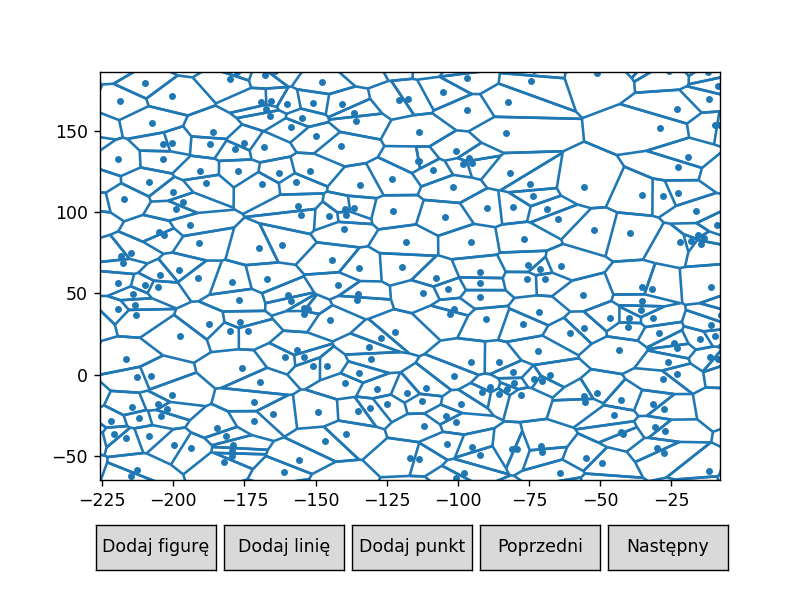

In [20]:
plot1 = Plot( lines = [LinesCollection(result)], points = [PointsCollection(points,marker = ".")] )
plot1.draw()